**CNN**

In [1]:
# Importing torch library, which is a popular one for deep learning
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.functional as F

# OS is a standard python library, which we use for accessing the file system.
import os

# Matplotllib is used for ploting graphs
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Shape of the training data (no of images, height, width) :  torch.Size([60000, 28, 28])
Shape of the testing data (no of images, height, width) :  torch.Size([10000, 28, 28])


###### An Example Image, Label pair ############




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


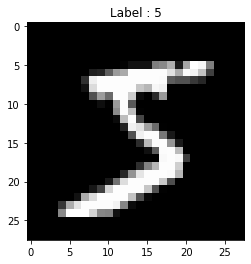

In [2]:
# Some code, to check if dataset is already downloaded.
DOWNLOAD_MNIST = False
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True

# Loading the training data
mnist_train = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# Similarly loading the testing data
mnist_test = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,                                     
    transform=torchvision.transforms.ToTensor(),    
    download=DOWNLOAD_MNIST,
)


# ploting one example
print("Shape of the training data (no of images, height, width) : ", mnist_train.train_data.size()) # (60000, 28, 28)
print("Shape of the testing data (no of images, height, width) : ", mnist_test.test_data.size())  # (10000, 28, 28)
print("\n")
print("###### An Example Image, Label pair ############")
plt.imshow(mnist_train.train_data[0].numpy(), cmap='gray')
plt.title('Label : %i' % mnist_train.train_labels[0])
plt.show()



Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) tensor(7)


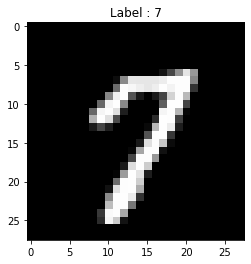

torch.Size([1, 28, 28]) tensor(8)


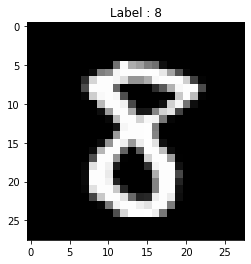

Mini batch size: images - torch.Size([1000, 1, 28, 28])  labels -  torch.Size([1000])
torch.Size([1, 28, 28]) tensor(3)


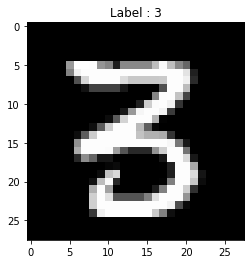

torch.Size([1, 28, 28]) tensor(9)


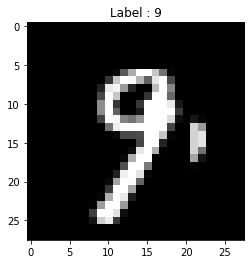

In [3]:
batch_size = 1000 # The mini batch size used for doing the training


# Data Loader for easy mini-batch return in training, the image batch shape will be (batch_size, 1, 28, 28)
train_loader = Data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = Data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=True)

count = 0
for mini_batch in train_loader:
    images, labels = mini_batch
    print('Mini batch size: images -', images.size(), ' labels - ', labels.size())
    for j in range(batch_size):
        print(images[j].size(), labels[j])
        plt.imshow(images[j][0].numpy(), cmap='gray')
        plt.title('Label : %i' % labels[j])
        plt.show()

# Some logic to break the loops so that we dont print the whole dataset.
        if j == 1:
            break
    if count == 1:
        break
        
    count +=1
    


In [4]:
# A CNN based Feature extractor
# Definining neural network in python by a class which inherits from nn.Module
class LeNet(nn.Module):
    """LeNet feature extractor model."""

    def __init__(self):
        """Init LeNet feature extractor model."""
        super(LeNet, self).__init__()

        # Defining the CNNfeature Extractor
        self.feature_extractor = nn.Sequential(
            # 1st conv layer
            # input [1 x 28 x 28]
            # output [20 x 12 x 12]
            nn.Conv2d(1, 6, kernel_size=5), # A Conv which converts an input with 1 channel to an output with 6 channels
            nn.MaxPool2d(kernel_size=2), # Max pooling subsampling operation
            nn.ReLU(), # Non linear activation function
            # 2nd conv layer
            # input [20 x 12 x 12]
            # output [50 x 4 x 4]
            nn.Conv2d(6, 16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        # Defining the Classifier
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, input):
        """Define a Forward pass of the LeNet."""
        out = self.feature_extractor(input) # Pass input through the feature extractor
        out = out.view(-1, 16 * 4 * 4) # Reshape the 2D to a vector
        out = self.classifier(out) # pass features through the classifier to get predictions
        return out




In [5]:
# Create an instance of the model
lenet = LeNet()


use_gpu = torch.cuda.is_available()
if use_gpu:
    lenet.cuda()

# Print out the size of parameters of each layer
for name, param in lenet.state_dict().items():
    print(name, '\n', param.size(), '\n')

feature_extractor.0.weight 
 torch.Size([6, 1, 5, 5]) 

feature_extractor.0.bias 
 torch.Size([6]) 

feature_extractor.3.weight 
 torch.Size([16, 6, 5, 5]) 

feature_extractor.3.bias 
 torch.Size([16]) 

classifier.0.weight 
 torch.Size([120, 256]) 

classifier.0.bias 
 torch.Size([120]) 

classifier.1.weight 
 torch.Size([84, 120]) 

classifier.1.bias 
 torch.Size([84]) 

classifier.3.weight 
 torch.Size([10, 84]) 

classifier.3.bias 
 torch.Size([10]) 



In [6]:
correct = 0.0
total = 0.0
for mini_batch in train_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    if use_gpu:
        images = images.cuda()
        labels = labels.cuda()
        
    images = Variable(images)
    
    # Doing the Forward pass
    result = lenet(images)
    
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of Test Data: 9.03%


In [7]:
loss_func = nn.CrossEntropyLoss()

# Set the learning rate
learning_rate = 0.001

optimizer = torch.optim.Adam(lenet.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, momentum=0.0)

####### Epoch  0
####### Epoch  1
####### Epoch  2
####### Epoch  3
####### Epoch  4
####### Epoch  5
####### Epoch  6
####### Epoch  7


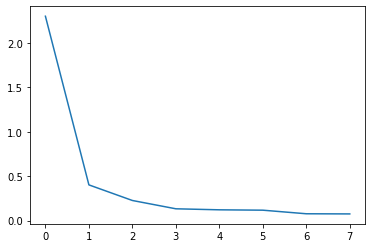

In [8]:
# The number of times we should iterate over the training data. 1 epoch = 1 pass over the training data
epoch = 8

# Train Model with train data

loss_history = []

for i in range(epoch):
    print('####### Epoch ', i)
    for j,[image,label] in enumerate(train_loader):
        # You can try with and without using GPUs, by setting this variable before the loop
        if use_gpu:
            image = image.cuda()
            label = label.cuda()
            
        image = Variable(image)
        label = Variable(label)
        
        
        optimizer.zero_grad() # zero out the gradients from the preivous step 
        predictions = lenet.forward(image) # Do forward pass on the current mini batch
        loss = loss_func(predictions, label) # Compute loss on the current mini batch
        loss.backward() # Do backward pass. That is compute all the gradients for the current minibatch
        optimizer.step() # Update the parameters using the gradients with the learning rate
        
        if j % 100 == 0:
            loss_history.append(loss.data.cpu().numpy())
                    
       # display.clear_output(wait=True)
plt.plot(loss_history)
plt.show()

In [9]:
correct = 0.0
total = 0.0
for mini_batch in test_loader:
    images, labels = mini_batch
    
    # You can try with and without using GPUs, by setting this variable before the loop
    if use_gpu:
        images = images.cuda()
        labels = labels.cuda()
        
    images = Variable(images)
    
    # Doing the Forward pass
    result = lenet(images)
    
    # Coverting the predictions to probabilities, by applying the softmax function
    result = F.softmax(result)
 
    # Finding the prediction with the largest probability
    _,pred = torch.max(result.data,1)
    
    total += labels.size(0)
    # correct is incremented by the numer of prediction which are correct (equal to the ground truth labels)
    correct += (pred == labels).sum()
    
print("Accuracy of Test Data: {0:.2f}%".format(correct/total *100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of Test Data: 97.91%
